# Evaluation Metrics: Session Overview

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

# Accuracy and Dummy Model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
1132/1409 # accuracy

0.8034066713981547

In [11]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores.append(score)

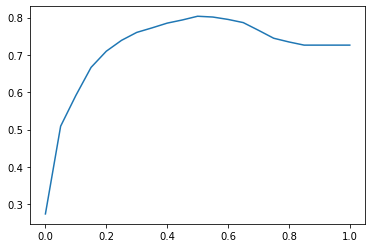

In [13]:
plt.plot(thresholds, scores)

# The highest score is around 0.5 threshold

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [16]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)

In [17]:
accuracy_score(y_val, y_pred >= 1)

# seems is quite good accuracy

0.7260468417317246

In [18]:
from collections import Counter

In [19]:
Counter(y_pred >= 1.0)

# Accuracy doesn't tell us how good the model performance is for this particular problem

Counter({False: 1409})

In [20]:
Counter(y_val)

# Accuracy isn't a good metric for Imbalance cases

Counter({0: 1023, 1: 386})

# Confusion Table
- Different types of errors and correct decisions
- Arranging them in a table

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [23]:
predict_positive[:5]

array([False, False, False,  True, False])

In [24]:
actual_positive[:5]

array([False, False, False,  True, False])

In [25]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [26]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [27]:
fp, fn

(101, 176)

In [28]:
confusion_matrix2 = np.array([
    [tn,fp],
    [fn,tp]
])

confusion_matrix2

array([[922, 101],
       [176, 210]])

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val,y_pred >= 0.5)

array([[922, 101],
       [176, 210]], dtype=int64)

In [30]:
(confusion_matrix2/ confusion_matrix2.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision and Recall

In [31]:
 (tp + tn) / (tp + tn + fp + fn) # accuracy

0.8034066713981547

In [32]:
p = tp / (tp+fp)
p # precision

0.6752411575562701

In [34]:
(tp+fp), tp


# We will sent promotional email to 311 customer, but only 210 are actually going to churn
# Which means 33% customer are mistakes, customer that are not supposed to get the promotional email.

(311, 210)

In [36]:
r = tp / (tp+fn)
r # recall

0.5440414507772021

In [37]:
tp, tp+fn

# We correctly identify 54% and 46% failed to identify if the customer is a churn.

(210, 386)

In [ ]:
# When we look accuracy, our model looks fine but when we see the precision and recall it is not.

# ROC Curves

In [38]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [39]:
fpr  = fp / (fp + tn)
fpr

0.09872922776148582

In [41]:
thresholds = np.linspace(0, 1 , 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [44]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [46]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [48]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr']=  df_scores.fp / (df_scores.fp + df_scores.tn)

In [49]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


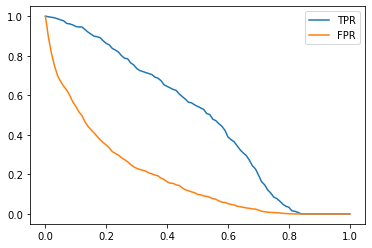

In [51]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random Model

In [53]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [54]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [58]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1 , 101)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr']=  df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [59]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [60]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


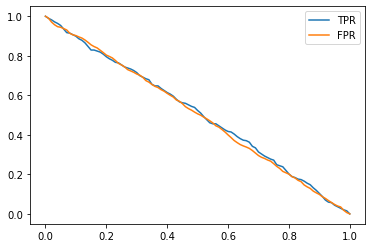

In [62]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## Ideal Model

In [63]:
num_neg = (y_val ==0).sum()
num_pos = (y_val ==1).sum()
num_neg, num_pos

(1023, 386)

In [64]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [66]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [68]:
1 - y_val.mean()

0.7260468417317246

In [69]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [70]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

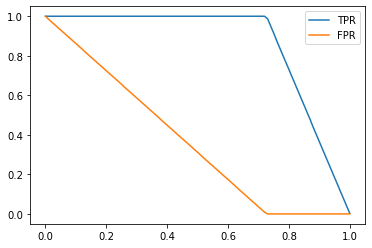

In [71]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

## Putting Everything Together

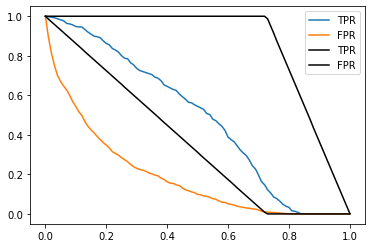

In [74]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color='black')

plt.legend()

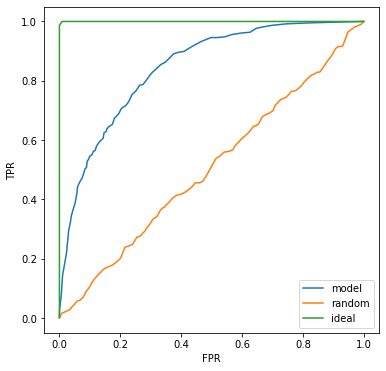

In [78]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

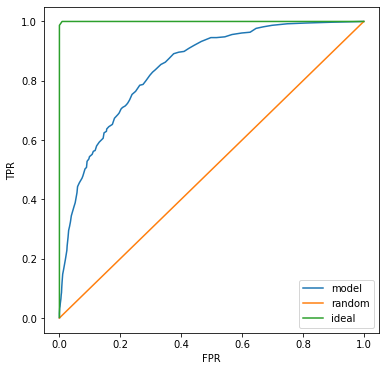

In [79]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC Curve in Skicit-learn

In [80]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

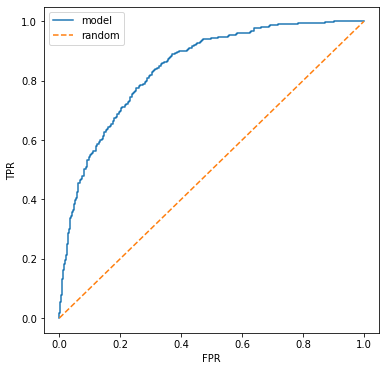

In [82]:
plt.figure(figsize=(6,6))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC AUC

In [83]:
 from sklearn.metrics import auc

In [84]:
auc(fpr,tpr)

0.843850505725819

In [85]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [86]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [89]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.843850505725819

In [88]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.843850505725819

## AUC Interpretation

In [91]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [92]:
import random

In [93]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
        
success/n # close to AUC score

0.842

In [104]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [105]:
(pos[pos_ind] > neg[neg_ind]).mean()

# How well our model orders positive and negative examples
# and how well it separates positive examples from the negative examples

0.84646

# Cross Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [130]:
def train(df,y_train, C=1):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [107]:
dv, model = train(df_train, y_train)

In [108]:
def predict(df,dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [110]:
y_pred = predict(df_val, dv, model)

In [111]:
from sklearn.model_selection import KFold

In [124]:
kfold = KFold(n_splits=10, shuffle = True, random_state=1)

In [114]:
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)

(3756, 1878)

In [115]:
len(df_full_train)

5634

In [121]:
from tqdm.auto import tqdm

In [125]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

C:\Users\Frags\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Frags\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [128]:
np.mean(scores).round(3), np.std(scores).round(3)

(0.841, 0.012)

In [138]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle = True, random_state=1)
    
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print(C, np.mean(scores).round(4), '+-', np.std(scores).round(4))

  0%|          | 0/7 [00:00<?, ?it/s]

0.001 0.8248 +- 0.009
0.01 0.8399 +- 0.0088
0.1 0.8407 +- 0.0082
0.5 0.84 +- 0.0065
1 0.8404 +- 0.0083
5 0.841 +- 0.0077
10 0.841 +- 0.0079


In [139]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

# If your dataset is quite large, hold out validation is fine.
# For bigger dataset maybe the fold is 2 or 3, 
# For smaller dataset the fold 5 or 10

0.8572386167896259